In [1]:
#MCMC FIT TO HST DATA INCLUDING BOTH ERI II AND CLUSTER, BINNED BY 30 PIXELS, AND MASKED 
#APPROPRIATELY
#PLUMMER PROFILE FOR ERI II, SERSIC PROFILE FOR CLUSTER
#UPDATED TO FIT ALL MODEL PARAMETERS INSTEAD OF JUST RICHNESS AND CENTER POSITION
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from astropy import wcs
from astropy.io import fits


In [2]:
cat = np.genfromtxt('/Volumes/Spare Data/photRun0520/drcPhot29Apr/catDir_PEGASUS-III/PEGASUS-III_fullCat.dat',
                    names=True)


In [4]:
good = np.logical_and(np.logical_and(cat['magr_f606w']<=30,cat['magr_f606w']-cat['magr_f814w']<=0),np.logical_or(cat['six_4_flag_f606w'] == 1,
                       cat['six_4_flag_f814w'] == 1))
# good = np.logical_or(cat['six_4_flag_f606w'] == 1,
#                        cat['six_4_flag_f814w'] == 1)

#                     cat['magRaw_v']<26)

# good = np.logical_and(cat['class_Star_i']>=0.8,
#                       cat['class_Star_v']>=0.8)

In [5]:
xgood = cat['xcenter_f606w'][good]
ygood = cat['ycenter_f606w'][good]

In [3]:
orientat = -106.8615917223524

In [6]:
theta = np.deg2rad(orientat)
c,s = np.cos(theta), np.sin(theta)

In [7]:
#BEGIN DEFINITION OF A MASK DESCRIBING THE PORTIONS OF THE IMAGE IN WHICH THERE IS DATA

IMAGE = Path([ [222, 4043], 
	[1, 1], 
	[4096, 101], 
	[4217, 4245], 
	[222, 4043]])

GAP = Path([ [100, 2079], 
	[106, 2034], 
	[4156, 2183], 
	[4151, 2231], 
	[100, 2079]])



IMG_BIT = 0b01
GAP_BIT = 0b10

In [8]:
xpath = np.array([222,1,4096,4217,222])
ypath = np.array([4043,1,101,4245,4043])

xgap = np.array([100,106,4156,4151,100])
ygap = np.array([2079,2034,2183,2231,2079])

In [9]:
x0 = 2523.17585813
y0 = 2395.41373595

In [10]:
xpT = c*(xpath-x0) - s*(ypath-(y0)) + x0
ypT = s*(xpath-x0) + c*(ypath-(y0)) + (y0)
xgT = c*(xgap-x0) - s*(ygap-(y0)) + x0
ygT = s*(xgap-x0) + c*(ygap-(y0)) + (y0)
xT = c*(xgood-x0) - s*(ygood-(y0)) + x0
yT = s*(xgood-x0) + c*(ygood-(y0)) + (y0)

In [11]:
xgood = xT
ygood = yT

In [12]:
#BEGIN DEFINITION OF A MASK DESCRIBING THE PORTIONS OF THE IMAGE IN WHICH THERE IS DATA

IMAGE = Path([ [4767, 4120], 
	[963, 5504], 
	[-129, 1556], 
	[3801, 238], 
	[4767, 4120]])

GAP = Path([ [2923,4806], 
	[2878,4813], 
	[1846,894], 
	[1893,885], 
	[2923,4806]])



IMG_BIT = 0b01
GAP_BIT = 0b10

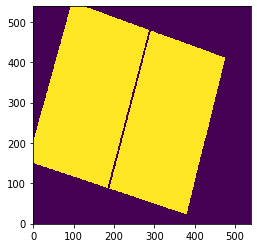

In [13]:
#DEFINE A GRID OF 30X30 PIXEL BINS COVERING THE IMAGE
NBINS = 540
XMIN,XMAX = 0,5400
YMIN,YMAX = 0,5400
XEDGE = np.linspace(XMIN,XMAX,NBINS)
YEDGE = np.linspace(XMIN,XMAX,NBINS)

#BIN CENTERS
XCENT = (XEDGE[1:] + XEDGE[:-1])/2.
YCENT = (YEDGE[1:] + YEDGE[:-1])/2.
#BIN SIZE
XDEL = XEDGE[1]-XEDGE[0]
YDEL = YEDGE[1]-YEDGE[0]

# Pre-calculate these instead of doing it in each evaluation of the model...
XX,YY= np.meshgrid(XCENT,YCENT,indexing='ij')


#USE THE MASKED REGIONS FROM ABOVE TO CREATE AN IMAGE MASK WITH THE APPROPRIATE BINNING
#REQUIRES FLATTENING THE ARRAYS
MASK = np.zeros((NBINS-1,NBINS-1))
image_mask = IMAGE.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
gap_mask = GAP.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
masked_indices_image = np.where(image_mask==1) # Array indices
masked_indices_gap = np.where(gap_mask==1) # Array indices
MASK[masked_indices_image] = 1
MASK[masked_indices_gap] = 0
IDX = np.where(MASK==1)

#DISPLAY THE MASK TO CHECK THAT IT'S CORRECT
plt.imshow(MASK.T,origin='lower')

In [14]:
def data(x,y):
    """ Calculate the binned data counts. This only needs to be done
    once (not at each model evaluation), but this seemed easier to
    understand if it paralleled the model counts calculation.

    Parameters
    ----------
    x : the x coordinate of the data
    y : the y coordinate of the data

    Returns
    -------
    data_counts : the data counts in each bin
    """
    data_counts,_,_ = np.histogram2d(x,y,bins=[XEDGE,YEDGE])
    return data_counts

In [15]:
data_counts = data(xgood,ygood)
data_counts_masked = np.copy(data_counts)
data_counts_masked[np.where(MASK==0)] = np.nan
# data_counts_masked = data_counts[IDX]

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

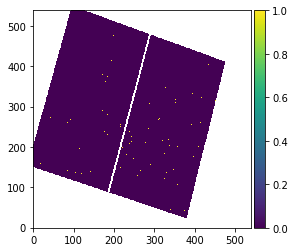

In [17]:
# fig, ax = plt.subplots()
# im = ax.imshow(data_counts_masked.T,origin='lower',cmap='viridis')

# # cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])

# fig.colorbar(im, orientation='horizontal')
# fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(data_counts_masked.T,origin='lower', cmap='viridis')

fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [18]:
from scipy.stats import kde

In [19]:
import scipy.ndimage

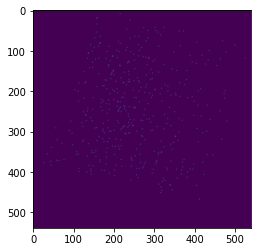

In [22]:
plt.imshow(data_counts,interpolation='gaussian')
plt.clim()

In [26]:
data_counts.shape

(539, 539)

In [27]:
from scipy.ndimage.filters import gaussian_filter
from matplotlib.pyplot import contour, show